In [7]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


# Define a simple linear regression function
def LinearRegressionFit(X, y):
    n = len(X)
    x_mean = sum(X) / n
    y_mean = sum(y) / n

    numerator = sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((X[i] - x_mean) ** 2 for i in range(n))

    b1 = numerator / denominator
    b0 = y_mean - b1 * x_mean

    return b0, b1

# Function to calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(actual, predicted, benchmark, percentage=False):
    n = len(actual)
    if n == 0 or benchmark == 0:
        return 0 if not percentage else 0.0  # Return 0 if no actual data or benchmark is 0

    sum_abs_errors = sum(abs(actual[i] - predicted[i]) for i in range(n))
    mean_abs_error = sum_abs_errors / n

    # Calculate MASE
    mase = mean_abs_error / (benchmark * 100) 
    # if not percentage else (mean_abs_error / benchmark) * 100
    return mase

conn = sqlite3.connect('renewable_predictions_test.db')


query = "SELECT * FROM predictions"

data = pd.read_sql_query(query, conn)

print(data)

conn.close()


                   Entity  Year  Electricity from hydro (TWh)  \
0             Afghanistan  2025                      1.007499   
1             Afghanistan  2026                      1.027357   
2             Afghanistan  2027                      1.047216   
3             Afghanistan  2028                      1.067075   
4             Afghanistan  2029                      1.086934   
...                   ...   ...                           ...   
6521  Western Africa (BP)  2046                     28.808868   
6522  Western Africa (BP)  2047                     29.127115   
6523  Western Africa (BP)  2048                     29.445363   
6524  Western Africa (BP)  2049                     29.763610   
6525  Western Africa (BP)  2050                     30.081858   

      Electricity from wind (TWh)  Electricity from solar (TWh)  \
0                        0.000000                      0.068261   
1                        0.000000                      0.071621   
2                 

In [8]:
# Handle missing values
data = data.fillna(0)
# data = data[~data['Entity'].str.contains(r'\(.*\)')]

print(data)

                   Entity  Year  Electricity from hydro (TWh)  \
0             Afghanistan  2025                      1.007499   
1             Afghanistan  2026                      1.027357   
2             Afghanistan  2027                      1.047216   
3             Afghanistan  2028                      1.067075   
4             Afghanistan  2029                      1.086934   
...                   ...   ...                           ...   
6521  Western Africa (BP)  2046                     28.808868   
6522  Western Africa (BP)  2047                     29.127115   
6523  Western Africa (BP)  2048                     29.445363   
6524  Western Africa (BP)  2049                     29.763610   
6525  Western Africa (BP)  2050                     30.081858   

      Electricity from wind (TWh)  Electricity from solar (TWh)  \
0                        0.000000                      0.068261   
1                        0.000000                      0.071621   
2                 

In [9]:
# Define the independent variables (features) and target variable
feature_columns = [
    'Electricity from hydro (TWh)',
    'Electricity from wind (TWh)',
    'Electricity from solar (TWh)',
    'Other renewables including bioenergy (TWh)',
    'Total (TWh)'
]

# Creating a new DataFrame for the years 2025 to 2051
years = list(range(2025, 2051))

# Initialize a list to store predictions for each entity and each column
all_predictions = []

# Group the data by the 'Region' column and rename it to 'Entity'
grouped_data = data.groupby('Entity')

# Iterate through each region group
for region, region_data in grouped_data:
    # Initialize dictionaries to store predictions for the current region for each column
    predictions = {'Entity': region}
    
    # Iterate through each column and perform linear regression
    for column in feature_columns:
        X = region_data['Year'].tolist()
        y = region_data[column].tolist()
        
        # Calculate b0 and b1 for the current region and column
        b0, b1 = LinearRegressionFit(X, y)
        
        # Make predictions for the current region and column for the years 2025 to 2050
        column_predictions = []
        for year in years:
            prediction = b0 + b1 * year
            if prediction < 0:
                prediction = 0

            # Append the prediction to the list of predictions for the current column
            column_predictions.append(prediction)
        
        # Store the predictions for the current column
        predictions[column] = column_predictions
    
    # Store the predictions for the current region
    all_predictions.append(predictions)

# Calculate MASE for each region and each energy production column
for prediction_data in all_predictions:
    entity = prediction_data['Entity']
    for column, predictions in prediction_data.items():
        if column != 'Entity': 
            actual_values = region_data[column].tolist() 
            benchmark = max(actual_values) - min(actual_values)  

            # Calculate MASE in absolute value and percentage
            mase_abs = mean_absolute_scaled_error(actual_values, predictions, benchmark, percentage=False)
            mase_percentage = mase_abs*10

            # Display MASE for the current region and column in absolute and percentage terms
            print(f"MASE for {column} in {entity}: {mase_abs} and {mase_percentage}% and {benchmark}")

MASE for Electricity from hydro (TWh) in Afghanistan: 0.18141160572337023 and 1.8141160572337023% and 0.1775832862789386
MASE for Electricity from wind (TWh) in Afghanistan: 0 and 0% and 0.0
MASE for Electricity from solar (TWh) in Afghanistan: 0.017935686274509796 and 0.17935686274509796% and 0.035996612083568635
MASE for Other renewables including bioenergy (TWh) in Afghanistan: 0.02650160116448325 and 0.2650160116448325% and 0.1939582156973465
MASE for Total (TWh) in Afghanistan: 0.22297328015952125 and 2.2297328015952127% and 0.14158667419536997
MASE for Electricity from hydro (TWh) in Africa: 8.863075218722294 and 88.63075218722294% and 0.1775832862789386
MASE for Electricity from wind (TWh) in Africa: 0 and 0% and 0.0
MASE for Electricity from solar (TWh) in Africa: 1.8409185865223416 and 18.409185865223417% and 0.035996612083568635
MASE for Other renewables including bioenergy (TWh) in Africa: 0.49499981500152673 and 4.949998150015268% and 0.1939582156973465
MASE for Total (TWh)

In [10]:
# Create a connection to the SQLite database 'mase__error.db'
conn_mase_error = sqlite3.connect('mase__error.db')
cursor_mase_error = conn_mase_error.cursor()

# Create a table if it doesn't exist in 'mase_error.db' to store MASE values
cursor_mase_error.execute('''
    CREATE TABLE IF NOT EXISTS MASE_ERROR (
        entity TEXT,
        energy TEXT,
        mase_abs REAL,
        mase_percentage REAL
    )
''')

# List to store existing data from the database
existing_data = []

# Retrieve existing data from the 'MASE_ERROR' table
cursor_mase_error.execute("SELECT * FROM MASE_ERROR")
rows = cursor_mase_error.fetchall()
for row in rows:
    existing_data.append(row)  # Storing existing data

# Iterate through the calculated MASE values and insert them into the 'MASE_ERROR' table
for prediction_data in all_predictions:
    region = prediction_data['Entity']
    for column, predictions in prediction_data.items():
        if column != 'Entity':
            actual_values = region_data[column].tolist()
            benchmark = max(actual_values) - min(actual_values)

            # Calculate MASE in absolute value and percentage
            mase_abs = mean_absolute_scaled_error(actual_values, predictions, benchmark, percentage=False)
            mase_percentage = mase_abs * 100

            # Check if the data is already in the database
            data_to_insert = (region, column, mase_abs, mase_percentage)
            if data_to_insert not in existing_data:
                # Insert the calculated MASE values into the 'MASE_ERROR' table
                cursor_mase_error.execute('''
                    INSERT INTO MASE_ERROR (entity, energy, mase_abs, mase_percentage)
                    VALUES (?, ?, ?, ?)
                ''', data_to_insert)

# Commit changes and close the connection to 'mase_error.db'
conn_mase_error.commit()
conn_mase_error.close()


In [11]:
#Display the data stored in database
conn_mase_error = sqlite3.connect('mase_error.db')

# Query to select all data from the 'MASE_ERROR' table
query = "SELECT * FROM MASE_ERROR WHERE entity = 'Australia'"

# Read data for Australia from the database into a DataFrame
data_for_australia = pd.read_sql_query(query, conn_mase_error)

# Close the connection to the database
conn_mase_error.close()

# Display the fetched data for Australia using Pandas DataFrame
print(data_for_australia)

      entity                                      energy  mase_abs  \
0  Australia                Electricity from hydro (TWh)  0.789232   
1  Australia                 Electricity from wind (TWh)  0.000000   
2  Australia                Electricity from solar (TWh)  2.721241   
3  Australia  Other renewables including bioenergy (TWh)  0.199930   
4  Australia                                 Total (TWh)  2.716358   

   mase_percentage  
0        78.923198  
1         0.000000  
2       272.124130  
3        19.993047  
4       271.635842  


      entity                                      energy  mase_abs  \
0  Australia                Electricity from hydro (TWh)  0.789232   
1  Australia                 Electricity from wind (TWh)  0.000000   
2  Australia                Electricity from solar (TWh)  2.721241   
3  Australia  Other renewables including bioenergy (TWh)  0.199930   
4  Australia                                 Total (TWh)  2.716358   

   mase_percentage  
0        78.923198  
1         0.000000  
2       272.124130  
3        19.993047  
4       271.635842  


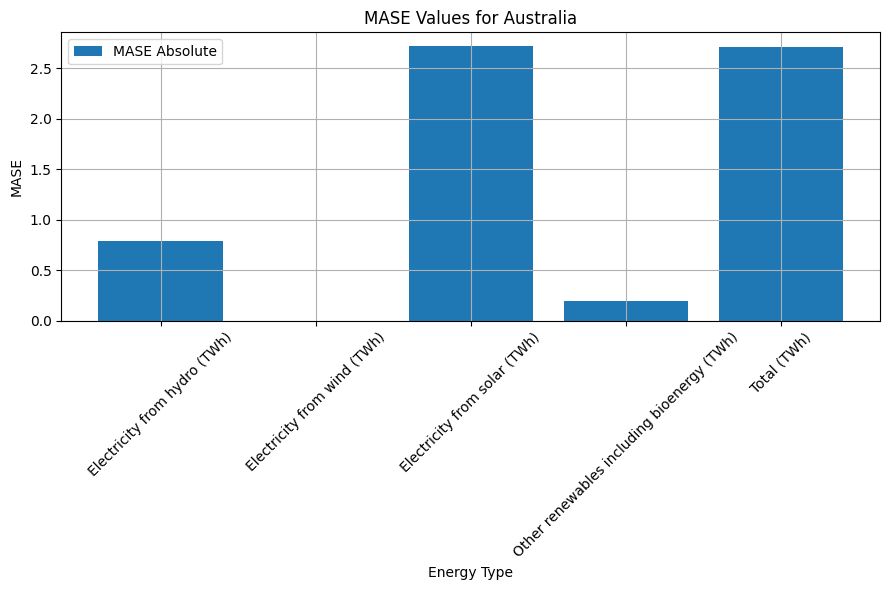

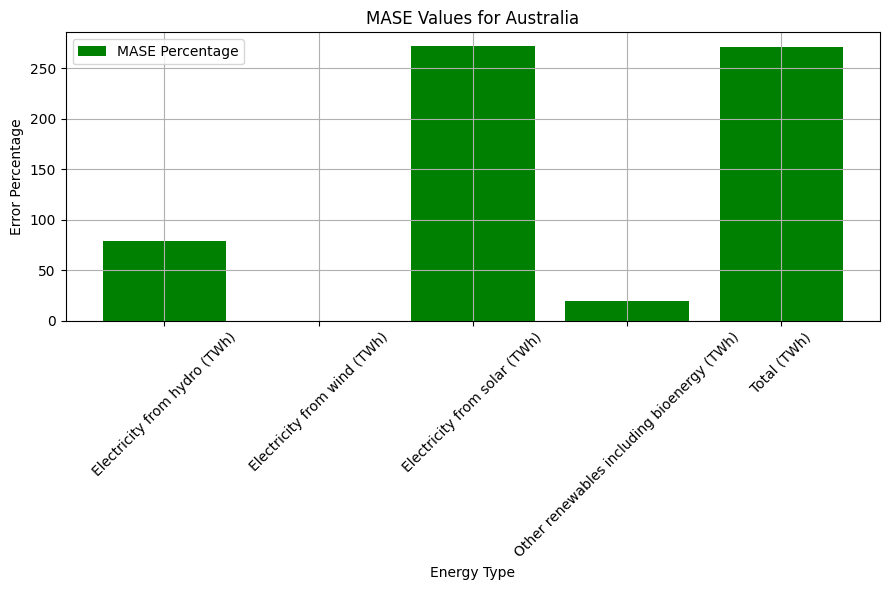

In [12]:

# Connect to the SQLite database 'mase_error.db'
conn_mase__error = sqlite3.connect('mase_error.db')

# Query to select data for the entity 'Australia' from the 'MASE_ERROR' table
query = "SELECT * FROM MASE_ERROR WHERE entity='Australia'"

# Read data for 'Australia' from the database into a DataFrame
data_for_Australia = pd.read_sql_query(query, conn_mase__error)

# Close the connection to the database
conn_mase__error.close()

# Display the fetched data using Pandas DataFrame
print(data_for_Australia.head())

# Plotting the data using Matplotlib
plt.figure(figsize=(9, 6))
plt.bar(data_for_Australia['energy'], data_for_Australia['mase_abs'], label='MASE Absolute')
# plt.bar(data_for_Australia['energy'], data_for_Australia['mase_percentage'], label='MASE Percentage')
plt.xlabel('Energy Type')
plt.ylabel('MASE')
plt.title('MASE Values for Australia')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


# Plotting the data using Matplotlib
plt.figure(figsize=(9, 6))
bars = plt.bar(data_for_Australia['energy'], data_for_Australia['mase_percentage'], label='MASE Percentage', color='green')
plt.xlabel('Energy Type')
plt.ylabel('Error Percentage')
plt.title('MASE Values for Australia')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()